In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
import datetime
import concurrent.futures
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import threading

In [ ]:
# # Now, from above, integrating partial scanning again!

# import sys
# import os
# import concurrent.futures
# sys.path.append(os.path.abspath('../..'))
# import pandas as pd
# import pyarrow as pa
# import pyarrow.parquet as pq
# from utlis.sync_utlis.sync_df_utlis import find_calib_file
# from utlis.scan_engine_utlis.scan_engine_utlis import (
#     read_failed_paths,
#     match_date_pattern,
#     assign_status_codes
# )
# from scan_engine.status_fields_config import STATUS_FIELDS_CONFIG

# # # Function to scan an individual folder (for parallel processing)
# # def scan_folder(folder_name, base_folder, failed_paths, config):
# #     folder_path = os.path.join(base_folder, folder_name)
# #     rec_files_data = []  # To store rec files and their status
# #     calib_files = []  # To store calibration files

# #     # Check for calibration files starting with 'calib'
# #     for file_name in os.listdir(folder_path):
# #         if file_name.startswith("calib"):
# #             calib_files.append(file_name)

# #     # Traverse subfolders within this folder
# #     for subfolder_name in os.listdir(folder_path):
# #         subfolder_path = os.path.join(folder_path, subfolder_name)

# #         # Check for subfolders starting with a digit (rec folders)
# #         if os.path.isdir(subfolder_path) and subfolder_name[0].isdigit():
# #             # Find calibration file for each subfolder
# #             calib_file = find_calib_file(subfolder_path)

# #             # Assign status codes dynamically based on the config
# #             rec_file_data = assign_status_codes(
# #                 folder_name, subfolder_path, calib_file, failed_paths, config
# #             )

# #             rec_file_data['rec_file'] = subfolder_name  # Add rec_file to the data
# #             rec_files_data.append(rec_file_data)

# #     return {
# #         'date_folder': folder_name,
# #         'calib_files': calib_files,  # Store the calibration files under date_folder level
# #         'rec_files_data': rec_files_data  # Each rec file with its status fields
# #     }

# # # Parallel version of the original log_folder_to_parquet function, with partial scan now.
# # # def log_folder_to_parquet(base_folder, parquet_file, failed_paths_file, config):
# # #     # Read manually inputted failed paths
# # #     failed_paths = read_failed_paths(failed_paths_file)

# # #     # Read the existing log to get already processed date folders
# # #     existing_df = pq.read_table(parquet_file).to_pandas()
# # #     logged_folders = existing_df['date_folder'].unique() if not existing_df.empty else []

# # #     # Get the list of current date folders that match the date pattern and are not logged yet
# # #     date_folders = [
# # #         f for f in os.listdir(base_folder) 
# # #         if os.path.isdir(os.path.join(base_folder, f)) and match_date_pattern(f) 
# # #         and f not in logged_folders  # Only include new folders
# # #     ]
    
# # #     # If there are no new folders, print a message and return
# # #     if not date_folders:
# # #         print("No new folders to scan.")
# # #         return

# # #     # Use ThreadPoolExecutor for parallel folder scanning
# # #     with concurrent.futures.ThreadPoolExecutor() as executor:
# # #         # Run scan_folder in parallel for each new date folder
# # #         log_data = list(executor.map(scan_folder, date_folders, [base_folder] * len(date_folders), [failed_paths] * len(date_folders), [config] * len(date_folders)))

# # #     # Convert the results into a DataFrame
# # #     df = pd.json_normalize(log_data, 'rec_files_data', ['date_folder', 'calib_files'])

# # #     # Dynamically ensure all relevant columns are strings based on config
# # #     status_columns = list(config.keys())
# # #     df[status_columns] = df[status_columns].astype(str)

# # #     # Create pyarrow Table and save as Parquet
# # #     table = pa.Table.from_pandas(df)
# # #     pq.write_table(table, parquet_file)

# # def log_folder_to_parquet(base_folder, parquet_file, failed_paths_file, config):
# #     # Read manually inputted failed paths
# #     failed_paths = read_failed_paths(failed_paths_file)

# #     # Initialize logged folders
# #     logged_folders = []

# #     # Check if the Parquet file exists
# #     if os.path.exists(parquet_file):
# #         # Read the existing log to get already processed date folders
# #         existing_df = pq.read_table(parquet_file).to_pandas()
# #         logged_folders = existing_df['date_folder'].unique() if not existing_df.empty else []
# #     else:
# #         print("No existing Parquet file found. Running full scan.")

# #     # Get the list of current date folders that match the date pattern
# #     date_folders = [
# #         f for f in os.listdir(base_folder) 
# #         if os.path.isdir(os.path.join(base_folder, f)) and match_date_pattern(f)
# #     ]
    
# #     # Filter for new folders not logged yet
# #     new_folders = [f for f in date_folders if f not in logged_folders]

# #     # If no new folders are found, print a message and return
# #     if not new_folders:
# #         print("No new folders to scan.")
# #         return

# #     # Use ThreadPoolExecutor for parallel folder scanning
# #     with concurrent.futures.ThreadPoolExecutor() as executor:
# #         # Run scan_folder in parallel for each new date folder
# #         log_data = list(executor.map(scan_folder, new_folders, [base_folder] * len(new_folders), [failed_paths] * len(new_folders), [config] * len(new_folders)))

# #     # Convert the results into a DataFrame
# #     df = pd.json_normalize(log_data, 'rec_files_data', ['date_folder', 'calib_files'])

# #     # Dynamically ensure all relevant columns are strings based on config
# #     status_columns = list(config.keys())
# #     df[status_columns] = df[status_columns].astype(str)

# #     # Create pyarrow Table and save as Parquet
# #     table = pa.Table.from_pandas(df)
# #     pq.write_table(table, parquet_file)
# #     print("all scannning done")






# # if __name__ == "__main__":
# #     base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Replace with your base folder
# #     save_path = os.path.join(base_folder, 'paret')
# #     failed_paths_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/mir_bundle_run/synced_folders/240914_failed_sum_test.txt'  # File containing failed paths

# #     if not os.path.exists(save_path):
# #         os.makedirs(save_path)

# #     parquet_file = os.path.join(save_path, "folder_log_encoded_numb_paralle_test_3.parquet")  # Output Parquet file

# #     # Run the full scan with parallel processing
# #     log_folder_to_parquet(base_folder, parquet_file, failed_paths_file, STATUS_FIELDS_CONFIG)

In [2]:

from utlis.sync_utlis.sync_df_utlis import find_calib_file
from utlis.scan_engine_utlis.scan_engine_utlis import (
    read_failed_paths,
    match_date_pattern,
    assign_status_codes,
)
from scan_engine.status_fields_config import STATUS_FIELDS_CONFIG

# Import functions from utils.py
from utlis.scan_engine_utlis.scan_log_utlis import (
    load_scan_log,
    save_scan_log,
    clean_scan_log,
    update_scan_log,
    get_folders_to_scan
)

def scan_folder(folder_name, base_folder, failed_paths, config, rec_files_to_scan):
    folder_path = os.path.join(base_folder, folder_name)
    rec_files_data = []  # To store rec files and their status
    calib_files = []  # To store calibration files

    # Check for calibration files starting with 'calib'
    for file_name in os.listdir(folder_path):
        if file_name.startswith("calib"):
            calib_files.append(file_name)

    # Traverse subfolders within this folder
    for subfolder_name in rec_files_to_scan:
        subfolder_path = os.path.join(folder_path, subfolder_name)

        # Check for subfolders starting with a digit (rec folders)
        if os.path.isdir(subfolder_path) and subfolder_name[0].isdigit():
            # Find calibration file for each subfolder
            calib_file = find_calib_file(subfolder_path)

            # Assign status codes dynamically based on the config
            rec_file_data = assign_status_codes(
                folder_name, subfolder_path, calib_file, failed_paths, config
            )

            rec_file_data['rec_file'] = subfolder_name  # Add rec_file to the data
            # Add date-time for update and some future
            rec_file_data['scan_time'] = datetime.datetime.now().isoformat()

            rec_files_data.append(rec_file_data)

    return {
        'date_folder': folder_name,
        'calib_files': calib_files,  # Store the calibration files under date_folder level
        'rec_files_data': rec_files_data  # Each rec file with its status fields
    }

def log_folder_to_parquet_sep(base_folder, failed_paths_file, config, force_rescan_rec_files=None, rescan_threshold_days=7):
    """Log folders and save Parquet in subfolders with partial scan support."""

    # Paths for scan log
    scan_log_path = os.path.join(base_folder, 'paret', 'scan_log.csv')

    # Load or initialize the scan log
    scan_log_df = load_scan_log(scan_log_path)

    # Read manually inputted failed paths
    failed_paths = read_failed_paths(failed_paths_file) if failed_paths_file else set()

    # Forced rescans
    # force_rescan_rec_files = [
    #     # ('2023-10-01', '001'),
    #     # ('2023-10-02', '002'),
    #     # Add more as needed
    # ]
    # force_rescan_rec_files_set = set(force_rescan_rec_files)
    
    if force_rescan_rec_files is None:
        force_rescan_rec_files = []
    force_rescan_rec_files_set = set(force_rescan_rec_files)



    # Rescan threshold
    # rescan_threshold_days = 7

    # Determine folders to scan
    folders_to_scan = get_folders_to_scan(base_folder, scan_log_df, rescan_threshold_days, force_rescan_rec_files_set)

    if not folders_to_scan:
        print("No new or modified folders to scan.")
        return

    # Use ThreadPoolExecutor for parallel folder scanning
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for date_folder, rec_files_to_scan in folders_to_scan.items():
            futures.append(
                executor.submit(
                    scan_folder,
                    date_folder,
                    base_folder,
                    failed_paths,
                    config,
                    rec_files_to_scan
                )
            )

        for future in concurrent.futures.as_completed(futures):
            folder_log = future.result()
            date_folder = folder_log['date_folder']
            calib_files = folder_log.get('calib_files', [])

            # Ensure 'calib_files' is always a list of strings
            calib_files = [str(f) for f in calib_files] if calib_files else []

            # Process and save each experiment's log separately
            for rec_file_data in folder_log['rec_files_data']:
                rec_file = rec_file_data['rec_file']
                subfolder_save_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

                # Ensure the experiment/rec_file folder exists
                os.makedirs(os.path.dirname(subfolder_save_path), exist_ok=True)

                # Add 'date_folder' and 'calib_files' to rec_file_data
                rec_file_data['date_folder'] = date_folder
                rec_file_data['calib_files'] = calib_files

                # Dynamically ensure all relevant columns are strings based on config
                status_columns = list(config.keys())
                df = pd.DataFrame([rec_file_data])
                df[status_columns] = df[status_columns].astype(str)

                # Convert the data into a DataFrame and save the Parquet file
                table = pa.Table.from_pandas(df)
                pq.write_table(table, subfolder_save_path)

                print(f"Log for {rec_file} saved at {subfolder_save_path}")

                # Update the scan log
                scan_log_df = update_scan_log(scan_log_df, date_folder, rec_file)

    # Clean up the scan log
    scan_log_df = clean_scan_log(scan_log_df, base_folder)

    # Save the updated scan log
    save_scan_log(scan_log_df, scan_log_path)

if __name__ == "__main__":
    base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Replace with your base folder
    # save_path = os.path.join(base_folder, 'paret')
    failed_paths_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/mir_bundle_run/synced_folders/240914_failed_sum_test.txt'  # File containing failed paths


    force_rescan_rec_files = [
        # ('2023-10-01', '001'),
        # ('2023-10-02', '002'),
        # Add more as needed
    ]
    rescan_threshold_days = 0.01 # 7 days, but guess if i mess up i can just change it to automatically rescan all, smile... #0.1

    log_folder_to_parquet_sep(base_folder, failed_paths_file, STATUS_FIELDS_CONFIG,
                              force_rescan_rec_files=force_rescan_rec_files,
                              rescan_threshold_days=rescan_threshold_days)


Log for 20240628_PMC_r1_11_43 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_08/20240628_PMC_r1_11_43/folder_log.parquet
Log for 20240628_PMC_r1_11_26 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_08/20240628_PMC_r1_11_26/folder_log.parquet
Log for 20240702_PMC_r1_12_02 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_08/20240702_PMC_r1_12_02/folder_log.parquet
Log for 24Anshu_f_paint_2mice saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice/folder_log.parquet
Log for 24Anshu_f_bleach_2mice saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_bleach_2mice/folder_log.parquet
Log for 24Anshu_f_paint_2mice_2 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice_2/folder_log.parquet
Log for 20240717_PMCr1 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240717_PMCr1/folder_lo

In [3]:
sys.path.append(os.path.abspath('../..'))
from utlis.scan_engine_utlis.scan_engine_utlis import read_all_parquet_files
base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"
all_df = read_all_parquet_files(base_folder)

In [3]:
# from utlis.scan_engine_utlis.scan_engine_utlis import read_all_parquet_files_auto_exclude
# base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"
# """actually can use read_all_parquet_files in cluster probably, i do not have calib folders locally so need to handle this hhh"""

# # Example usage
# # base_folder = "/path/to/your/base_folder"  # Replace with your base folder
# combined_df = read_all_parquet_files_auto_exclude(base_folder, exclude_columns = ['calib_files']
# )

# # Display or use the combined DataFrame
# print(combined_df)

pyarrow.Table
mir_generate_param: string
sync: string
rec_file: string
scan_time: string
date_folder: string
----
mir_generate_param: [["0"],["0"],...,["1"],["1"]]
sync: [["3"],["3"],...,["0"],["0"]]
rec_file: [["1686940_left_right"],["1686940_left_right_2"],...,["20240916v1r1_17_55"],["20240916v1r1_19_18"]]
scan_time: [["2024-10-21T11:17:10.424509"],["2024-10-21T11:17:10.430818"],...,["2024-10-21T11:17:10.432649"],["2024-10-21T11:17:10.431621"]]
date_folder: [["2024_06_25"],["2024_06_25"],...,["2024_10_07"],["2024_10_07"]]


In [12]:
# import pyarrow.compute as pc

# # Define a mask to identify rows with 'False' or null values in specific columns
# mask_false_mir = pc.equal(table['mir_generate_param'], 'False')
# mask_false_sync = pc.equal(table['sync'], 'False')
# mask_false_z_adjusted = pc.equal(table['z_adjusted'], 'False')

# mask_null_mir = pc.is_null(table['mir_generate_param'])
# mask_null_sync = pc.is_null(table['sync'])
# mask_null_z_adjusted = pc.is_null(table['z_adjusted'])

# # Combine the masks using multiple pc.or_() calls
# mask = pc.or_(
#     pc.or_(mask_false_mir, mask_false_sync),
#     pc.or_(mask_false_z_adjusted, 
#            pc.or_(mask_null_mir, 
#                   pc.or_(mask_null_sync, mask_null_z_adjusted)))
# )

# # Apply the mask to filter the rows
# filtered_table = table.filter(mask)

# # Print the filtered rows for inspection
# print(filtered_table.to_pandas())  # Convert to pandas for easier viewing in Jupyter Notebook


    mir_generate_param    sync z_adjusted  \
0                False   False      False   
1                False  FAILED      False   
2                False  FAILED      False   
3                False   False      False   
4                False   False      False   
..                 ...     ...        ...   
101              False  FAILED      False   
102              False   False      False   
103              False   False      False   
104              False   False      False   
105              False   False      False   

                                rec_file scan_time date_folder  
0         1691486_left_right_habituation      None  2024_07_03  
1               1691486_left_habituation      None  2024_07_03  
2             1691486_left_caffeine_1050      None  2024_07_03  
3       1691486_left_right_caffeine_1448      None  2024_07_03  
4             1691486_left_caffeine_1051      None  2024_07_03  
..                                   ...       ...         ...  
101 

In [4]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    pc.equal(table['mir_generate_param'], '0'),
    pc.not_equal(table['sync'], '3'),
    # pc.not_equal(table['date_folder'], '2024_10_03_micecolor_test'),
)
# filter_mask = pc.and_(
#     pc.and_(
#         pc.equal(table['mir_generate_param'], '0'),
#         pc.not_equal(table['sync'], '3')
#     ),
#     pc.not_equal(table['date_folder'], '2024_10_03_micecolor_test')
# )


# Apply the filter and print the results
filtered_table = table.filter(filter_mask)

# Print each row of the filtered table
print(filtered_table.to_pandas())  # This will display the filtered data in a familiar pandas-like format


  mir_generate_param sync      rec_file                   scan_time  \
0                  0    0  20240819V1r2  2024-10-28T17:06:22.180430   

  date_folder     calib_files  
0  2024_10_03  [calib_for_v1]  


In [6]:
filtered_table

pyarrow.Table
mir_generate_param: string
sync: string
rec_file: string
scan_time: string
date_folder: string
----
mir_generate_param: [["0"],["0"],...,["0"],["0"]]
sync: [["0"],["0"],...,["0"],["0"]]
rec_file: [["20240717_PMCr2"],["20240707-PMC-r1"],...,["20240819_V1_r1_2"],["20240819V1r2"]]
scan_time: [["2024-10-21T11:17:10.448842"],["2024-10-21T11:17:10.432419"],...,["2024-10-21T11:17:10.433018"],["2024-10-21T11:17:10.448799"]]
date_folder: [["2024_08_29"],["2024_09_18"],...,["2024_09_18"],["2024_10_03"]]

In [6]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.exe_engine_utlis.mir_generate_param_modu import mir_generate_param_z

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder)
    calib_path = rec_file_data['calib_path'] if 'calib_path' in rec_file_data else os.path.join(combined_path, 'calib_before') #calib_before*
    calib_path = os.path.join(base_folder, date_folder, calib_path)
    if not calib_path:  # Check for empty or None calib_path
        print(f'No calib folder found. Aborting. {combined_path}/{rec_file}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'

    # Call your processing function
    ssssta = mir_generate_param_z(combined_path, calib_path, rec_file, output_file)
    print("mir_generate_param ran successfully.")

    # After processing, update the status in the specific Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    # Load the existing Parquet file
    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()  # Convert to pandas for easier manipulation
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return

    if ssssta is True:
        # Update the status field (assuming 'sync' is the column)
        df['mir_generate_param'] = '1'  # Set status to '1' for processed

        # Add scan_time (or other updates)
        df['scan_time'] = datetime.datetime.now().isoformat()

        # Write the updated DataFrame back to the Parquet file
        updated_table = pa.Table.from_pandas(df)
        pq.write_table(updated_table, parquet_file_path)

        print(f"Updated Parquet file at {parquet_file_path} with new status.")
    else:
        print(f'processed failed. please check {combined_path}/{rec_file}')

# Function to handle sequential processing and status updates
def sequential_process_and_update(filtered_table, base_folder):
    # Convert PyArrow table to pandas DataFrame
    filtered_df = filtered_table.to_pandas()

    # Process each row sequentially
    for row in filtered_df.itertuples(index=False):
        try:
            process_unit_and_update_status(row._asdict(), base_folder)
        except Exception as e:
            print(f"Error in processing: {e}")

# Example function call
# filtered_table = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table, base_folder)


Found 6 calibration files.
Frame count: 14243
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/calib_for_v1/hires_cam1_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/calib_for_v1/hires_cam2_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/calib_for_v1/hires_cam3_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/calib_for_v1/hires_cam4_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/calib_for_v1/hires_cam5_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/calib_for_v1/hires_cam6_params.mat
Data saved to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/20240819V1r2/2024_10_03_20240819V1r2_calib_for_v1_label3d_dannce.mat
mir_generate_param ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/20240819V1r2/folder_log.parquet with new status.


In [ ]:


# calib_paths = ['calib_before', 'calib_after', 'calib_custom', 'calib_backup']  # Define multiple calib paths
# process_unit_with_multiple_calib_paths(rec_file_data, base_folder, calib_paths)

In [4]:
# # too lazy to write general/reuseable codes, thus
# # below is only to process mir_generate_param

# import os
# import concurrent.futures
# import pyarrow as pa
# import pyarrow.parquet as pq
# import pandas as pd
# import datetime
# sys.path.append(os.path.abspath('../..'))
# from utlis.exe_engine_utlis.mir_generate_param_modu import mir_generate_param_z

# # Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file
# def process_unit_and_update_status(rec_file_data, base_folder):
#     date_folder = rec_file_data['date_folder']
#     rec_file = rec_file_data['rec_file']
    
#     # Generate the paths needed for processing
#     combined_path = os.path.join(base_folder, date_folder)
#     print(combined_path)
#     calib_path = rec_file_data['calib_path'] if 'calib_path' in rec_file_data else os.path.join(combined_path, 'calib_before')
#     # calib_path = os.path.join(combined_path, calib_path)
#     print(calib_path)
#     if not calib_path:  # Check for empty or None calib_path
#         print(f'No calib folder found. Aborting. {combined_path}/{rec_file}')
#         return
    
#     output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'

#     # Call your processing function
#     mir_generate_param_z(combined_path, calib_path, rec_file, output_file)
#     print("mir_generate_param ran successfully.")

#     # After processing, update the status in the specific Parquet file
#     parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

#     # Load the existing Parquet file
#     try:
#         table = pq.read_table(parquet_file_path)
#         df = table.to_pandas()  # Convert to pandas for easier manipulation
#     except FileNotFoundError:
#         print(f"Parquet file not found at {parquet_file_path}")
#         return

#     # Update the status field (assuming 'sync' is the column)
#     df['mir_generate_param'] = '1'  # Set status to '1' for processed

#     # Add scan_time (or other updates)
#     df['scan_time'] = datetime.datetime.now().isoformat()

#     # Write the updated DataFrame back to the Parquet file
#     updated_table = pa.Table.from_pandas(df)
#     pq.write_table(updated_table, parquet_file_path)

#     print(f"Updated Parquet file at {parquet_file_path} with new status.")

# # Function to handle parallel processing and status updates
# def parallel_process_and_update(filtered_table, base_folder):
#     # Convert PyArrow table to pandas DataFrame
#     filtered_df = filtered_table.to_pandas()

#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = [
#             executor.submit(process_unit_and_update_status, row._asdict(), base_folder)
#             for row in filtered_df.itertuples(index=False)
#         ]
        
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 future.result()  # Handle any exceptions
#             except Exception as e:
#                 print(f"Error in processing: {e}")

# # Example function call
# # filtered_table = [...]  # Your filtered PyArrow table here
# # base_folder = '/path/to/your/base_folder'
# parallel_process_and_update(filtered_table_for_sync, base_folder)


/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/calib_before
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/calib_before
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_29
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_29/calib_before
Found 6 calibration files.
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/calib_before
Found 0 calibration files.
no calib file found. skipping. calib path of /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_29/calib_before
mir_generate_param ran successfully.
Found 6 calibration files.
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/calib_before
Found 0 calibration files.
no calib file found. skipping. calib path of /hpc/group/tdunn/Bryan_Rigs/BigOpenFie

In [21]:
# from utlis.scan_engine_utlis.scan_engine_utlis import read_all_parquet_files_auto_exclude
# base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"
# """actually can use read_all_parquet_files in cluster probably, i do not have calib folders locally so need to handle this hhh"""

# # Example usage
# # base_folder = "/path/to/your/base_folder"  # Replace with your base folder
# combined_df = read_all_parquet_files_auto_exclude(base_folder, exclude_columns = ['calib_files']
# )

# # Display or use the combined DataFrame
# print(combined_df)

pyarrow.Table
mir_generate_param: string
sync: string
z_adjusted: string
rec_file: string
scan_time: string
date_folder: string
----
mir_generate_param: [["0"],["0"],...,["0"],["0"]]
sync: [["3"],["3"],...,["1"],["1"]]
z_adjusted: [["0"],["0"],...,["2"],["2"]]
rec_file: [["1686940_left_right"],["1686940_left_right_2"],...,["20240916v1r1_18_53"],["20240916v1r1_19_18"]]
scan_time: [["2024-10-15T15:47:18.496021"],["2024-10-15T15:47:18.498828"],...,["2024-10-15T16:38:36.504311"],["2024-10-15T16:38:37.212976"]]
date_folder: [["2024_06_25"],["2024_06_25"],...,["2024_10_07"],["2024_10_07"]]


In [17]:
# import pyarrow.compute as pc
# table = all_df #combined_df
# # Filter mir_generate_param == 0 and sync != 3
# filter_mask = pc.and_(
#     pc.equal(table['mir_generate_param'], '0'),
#     pc.not_equal(table['sync'], '3'),
#     # pc.not_equal(table['sync'], '3')
# )

# # Apply the filter and print the results
# filtered_table = table.filter(filter_mask)

# # Print each row of the filtered table
# print(filtered_table.to_pandas())  # This will display the filtered data in a familiar pandas-like format

   mir_generate_param sync                  rec_file  \
0                   1    1              1686940_left   
1                   1    1             1686940_left2   
2                   1    1          1686940_no_holes   
3                   1    1      1686940_left_right_2   
4                   1    1              1686941_left   
..                ...  ...                       ...   
75                  1    0              20240916V1r1   
76                  1    0              20240916V1r2   
77                  1    0  20240916v1r1_15_05_30min   
78                  1    0        20240916v1r1_17_55   
79                  1    0        20240916v1r1_19_18   

                     scan_time date_folder  \
0   2024-10-21T14:31:07.271955  2024_06_26   
1   2024-10-21T14:31:07.160803  2024_06_26   
2   2024-10-21T14:31:07.588016  2024_06_26   
3   2024-10-21T14:31:07.591349  2024_06_27   
4   2024-10-21T14:31:07.775808  2024_06_27   
..                         ...         ...   
75  2

In [9]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    pc.equal(table['mir_generate_param'], '1'),
    # pc.not_equal(table['sync'], '3'),
    pc.equal(table['sync'], '0')
)

# Apply the filter and print the results
filtered_table_for_sync = table.filter(filter_mask) # seems that one can just be here. other wise filter mask or something.

# Print each row of the filtered table
print(filtered_table_for_sync.to_pandas())  # This will display the filtered data in a familiar pandas-like format

  mir_generate_param sync                  rec_file  \
0                  1    0            20240717_PMCr1   
1                  1    0            20240717_PMCr2   
2                  1    0            20240730_PMCr2   
3                  1    0            20240717_PMCr2   
4                  1    0            20240819-V1-r2   
5                  1    0  20240916v1r1_15_05_30min   
6                  1    0        20240916v1r1_17_55   

                    scan_time date_folder                  calib_files  
0  2024-10-28T15:11:32.631496  2024_08_26                           []  
1  2024-10-28T15:11:32.633331  2024_08_26                           []  
2  2024-10-28T15:11:32.632555  2024_08_26                           []  
3  2024-10-28T15:11:32.719169  2024_08_29         [calib_before_18_49]  
4  2024-10-28T15:11:32.716344  2024_09_18         [calib_before_13_17]  
5  2024-10-28T15:11:32.705793  2024_10_07  [calib_before, calib_15_52]  
6  2024-10-28T15:11:32.709753  2024_10_07  [cali

In [5]:
# if sync fail, this is used to delete all synced files...
# import os
# import concurrent.futures

# # Function to delete all files ending with '_label3d_dannce.mat' in the specified folder
# def delete_label3d_files_in_folder(rec_file_data, base_folder):
#     date_folder = rec_file_data['date_folder']
#     rec_file = rec_file_data['rec_file']
    
#     # Generate the combined path
#     combined_path = os.path.join(base_folder, date_folder, rec_file)
    
#     # Check if the folder exists
#     if not os.path.exists(combined_path):
#         print(f"Folder not found: {combined_path}")
#         return
    
#     # Find and delete all files ending with '_label3d_dannce.mat'
#     for file_name in os.listdir(combined_path):
#         if file_name.endswith('_label3d_dannce.mat'):
#             file_path = os.path.join(combined_path, file_name)
#             os.remove(file_path)
#             print(f"Deleted file: {file_path}")

# # Function to handle parallel deletion using filtered_table
# def parallel_delete_label3d_files(filtered_table, base_folder):
#     # Convert PyArrow table to pandas DataFrame
#     filtered_df = filtered_table.to_pandas()

#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = [
#             executor.submit(delete_label3d_files_in_folder, row._asdict(), base_folder)
#             for row in filtered_df.itertuples(index=False)
#         ]
        
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 future.result()  # Handle any exceptions
#             except Exception as e:
#                 print(f"Error during deletion: {e}")

# # Example function call
# # filtered_table = [...]  # Your filtered PyArrow table here
# # base_folder = '/path/to/your/base_folder'
# parallel_delete_label3d_files(filtered_table_for_sync, base_folder)


Deleted file: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_19_18/2024_10_07_20240916v1r1_19_18_calib_before_label3d_dannce.matDeleted file: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_04/20240916V1r2/2024_10_04_20240916V1r2_calib_before_label3d_dannce.mat
Deleted file: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_04/20240819V1r1_20_10/2024_10_04_20240819V1r1_20_10_calib_before_label3d_dannce.mat
Deleted file: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240717_PMCr1/2024_08_26_20240717_PMCr1_calib_before_label3d_dannce.mat
Deleted file: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_04/20240819V1r1_21_40/2024_10_04_20240819V1r1_21_40_calib_before_label3d_dannce.mat
Deleted file: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_04/20240819V1r1_21_05/2024_10_04_20240819V1r1_21_05_calib_before_label3d_dannce.mat
Deleted file: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240717_PMCr2/2024_08_2

Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240707-PMC-r1


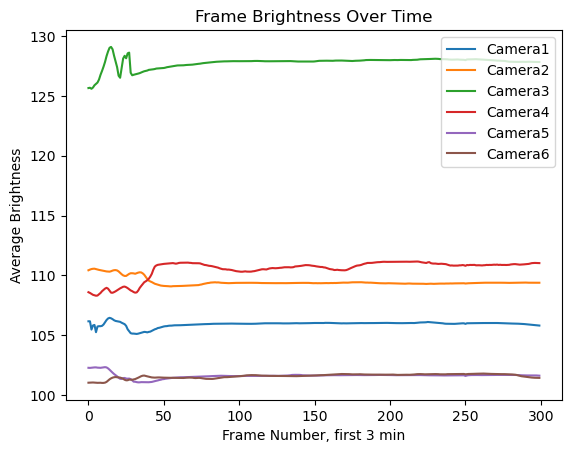

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240707-PMC-r1: {'Camera1': [], 'Camera2': [], 'Camera3': [], 'Camera4': [], 'Camera5': [], 'Camera6': []}
Skipping process_calibration_data for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240707-PMC-r1 due to missing drop frames
please mannually process /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240707-PMC-r1
Failed processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240707-PMC-r1, status set to 3.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240707-PMC-r1/folder_log.parquet with new status.
Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1


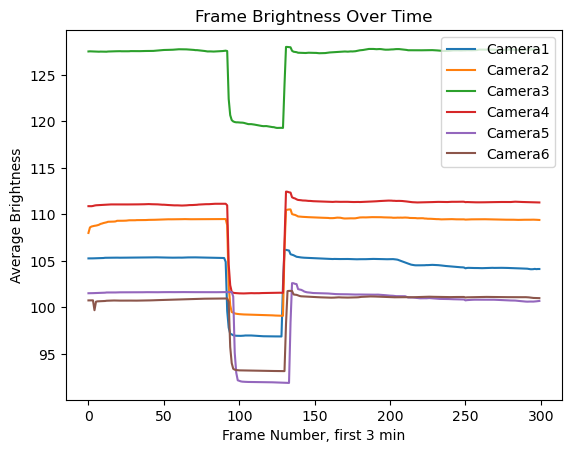

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1: {'Camera1': [92], 'Camera2': [93, 94], 'Camera3': [93], 'Camera4': [93, 94], 'Camera5': [97, 98], 'Camera6': [94]}
Processed drop frames: {'Camera1': 92, 'Camera2': 94, 'Camera3': 93, 'Camera4': 94, 'Camera5': 98, 'Camera6': 94}
92
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1/df_synced_20240819_V1_r1_2024_09_18_20240819_V1_r1_calib_before_13_17_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1
Moved prior calibration file to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1/prev_calib
Sync ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1/folder_log.parquet with new status.
Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1_2


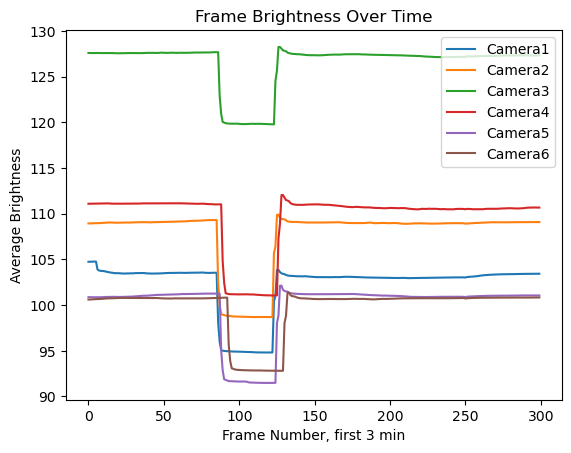

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1_2: {'Camera1': [86, 87], 'Camera2': [86, 87], 'Camera3': [87, 88], 'Camera4': [89, 90], 'Camera5': [88, 89], 'Camera6': [93]}
Processed drop frames: {'Camera1': 87, 'Camera2': 87, 'Camera3': 88, 'Camera4': 90, 'Camera5': 89, 'Camera6': 93}
87
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1_2/df_synced_20240819_V1_r1_2_2024_09_18_20240819_V1_r1_2_calib_before_13_17_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1_2
Moved prior calibration file to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1_2/prev_calib
Sync ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819_V1_r1_2/folder_log.parquet with new status.
Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03/20240819

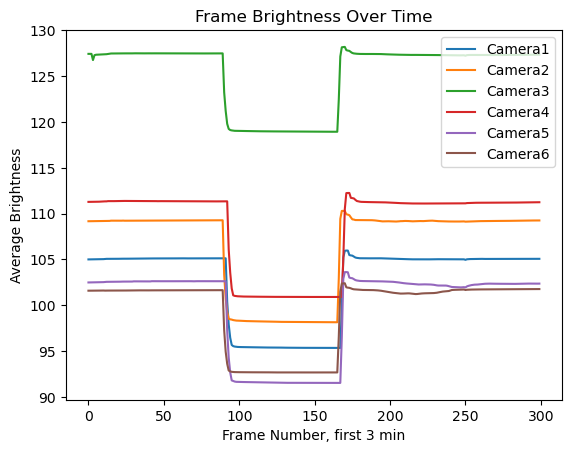

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_bleach_2mice: {'Camera1': [92, 93], 'Camera2': [90, 91], 'Camera3': [90, 91], 'Camera4': [93, 94], 'Camera5': [92, 93], 'Camera6': [90, 91]}
Processed drop frames: {'Camera1': 93, 'Camera2': 91, 'Camera3': 91, 'Camera4': 94, 'Camera5': 93, 'Camera6': 91}
91
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_bleach_2mice/df_synced_24Anshu_f_bleach_2mice_2024_10_03_micecolor_test_24Anshu_f_bleach_2mice_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_bleach_2mice
Moved prior calibration file to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_bleach_2mice/prev_calib
Sync ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_

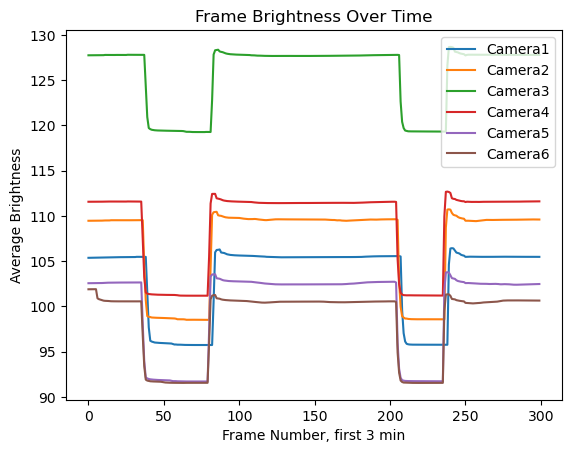

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice: {'Camera1': [39, 40, 208, 209], 'Camera2': [37, 38, 206, 207], 'Camera3': [38, 39, 207, 208], 'Camera4': [36, 37, 205, 206], 'Camera5': [36, 37, 205, 206], 'Camera6': [36, 37, 205, 206]}
Processed drop frames: {'Camera1': 40, 'Camera2': 38, 'Camera3': 39, 'Camera4': 37, 'Camera5': 37, 'Camera6': 37}
37
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice/df_synced_24Anshu_f_paint_2mice_2024_10_03_micecolor_test_24Anshu_f_paint_2mice_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice
Moved prior calibration file to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice/prev_calib
Sync ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/

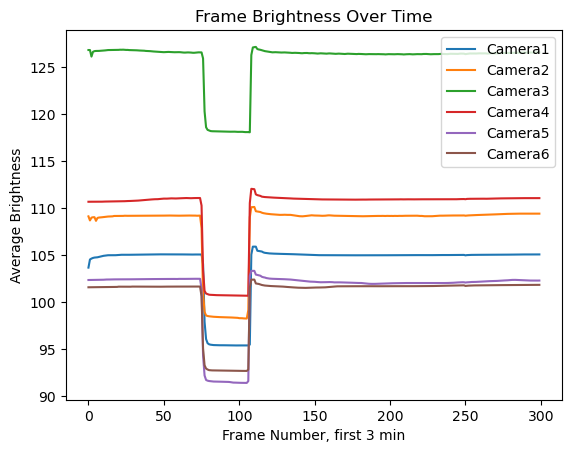

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice_2: {'Camera1': [77], 'Camera2': [76, 77], 'Camera3': [77], 'Camera4': [76, 77], 'Camera5': [76, 77], 'Camera6': [76]}
Processed drop frames: {'Camera1': 77, 'Camera2': 77, 'Camera3': 77, 'Camera4': 77, 'Camera5': 77, 'Camera6': 76}
76
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice_2/df_synced_24Anshu_f_paint_2mice_2_2024_10_03_micecolor_test_24Anshu_f_paint_2mice_2_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice_2
Moved prior calibration file to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_paint_2mice_2/prev_calib
Sync ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_03_micecolor_test/24Anshu_f_pain

In [8]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import process_sync

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file sequentially
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder, rec_file)
    calib_path = rec_file_data.get('calib_path', os.path.join(base_folder, 'calib_before'))
    
    if not calib_path:
        print(f'No calib folder found. Aborting. {combined_path}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'
    print(f"Processing: {combined_path}")
    
    # Call the sync processing function
    sync_status = process_sync(combined_path, threshold=2, max_frames=300)
    if sync_status is True:
        print("Sync ran successfully.")
    else:
        print(f"please mannually process {combined_path}")

    # Update the status in the Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return
    
    # status = '1' if sync_status else '3'
    status = '3' if not sync_status else '1'
    if status == '3':
        print(f"Failed processing: {combined_path}, status set to 3.")
    
    # Update status and scan_time
    df['sync'] = status
    df['scan_time'] = datetime.datetime.now().isoformat()

    # Write back to the Parquet file
    updated_table = pa.Table.from_pandas(df)
    pq.write_table(updated_table, parquet_file_path)
    print(f"Updated Parquet file at {parquet_file_path} with new status.")
   
# Sequentially process and update the status for each rec_file
def sequential_process_and_update(filtered_table, base_folder):
    filtered_df = filtered_table.to_pandas()
    
    for _, row in filtered_df.iterrows():
        process_unit_and_update_status(row.to_dict(), base_folder)

# Example function call
# filtered_table_for_sync = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table, base_folder)


In [ ]:
# import pyarrow.compute as pc
# table = combined_df
# # Filter mir_generate_param == 0 and sync != 3
# filter_mask = pc.and_(
#     pc.equal(table['mir_generate_param'], '1'),
#     # pc.not_equal(table['sync'], '3'),
#     pc.equal(table['sync'], '0')
# )

# # Apply the filter and print the results
# filtered_table_for_sync = table.filter(filter_mask) # seems that one can just be here. other wise filter mask or something.

# # Print each row of the filtered table
# print(filtered_table_for_sync.to_pandas())  # This will display the filtered data in a familiar pandas-like format

Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240717_PMCr2


KeyboardInterrupt: 

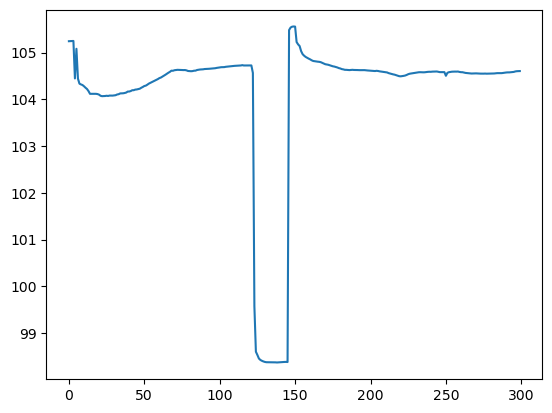

In [7]:
def process_single_unit(filtered_table, base_folder):
    # Convert PyArrow table to pandas DataFrame
    filtered_df = filtered_table.to_pandas()

    if filtered_df.empty:
        print("No data to process.")
        return

    # Select the first row to process
    first_row = filtered_df.iloc[0]

    try:
        # Convert the first row (a pandas Series) to a dictionary
        process_unit_and_update_status(first_row.to_dict(), base_folder)
        print("Processed single unit successfully.")
    except Exception as e:
        print(f"Error in processing single unit: {e}")

# Example function call for testing a single unit
# filtered_table_for_sync = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'

process_single_unit(filtered_table_for_sync, base_folder)


In [21]:
# # failed parallel processing.
# # too lazy to write general/reuseable codes, thus
# # below is only to process sync...

# import os
# import concurrent.futures
# import pyarrow as pa
# import pyarrow.parquet as pq
# import pandas as pd
# import datetime
# sys.path.append(os.path.abspath('../..'))
# from utlis.sync_utlis.sync_df_utlis import process_sync

# # Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file
# def process_unit_and_update_status(rec_file_data, base_folder):
#     date_folder = rec_file_data['date_folder']
#     rec_file = rec_file_data['rec_file']
    
#     # Generate the paths needed for processing
#     combined_path = os.path.join(base_folder, date_folder, rec_file)
#     calib_path = rec_file_data['calib_path'] if 'calib_path' in rec_file_data else os.path.join(base_folder, 'calib_before')
    
#     if not calib_path:  # Check for empty or None calib_path
#         print(f'No calib folder found. Aborting. {combined_path}')
#         return
    
#     output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'
#     print(combined_path)
#     # Call your processing function
#     sync_status = process_sync(combined_path, threshold=2.5, max_frames=300)
#     print("sync ran successfully.")

#     # After processing, update the status in the specific Parquet file
#     parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

#     # Load the existing Parquet file
#     try:
#         table = pq.read_table(parquet_file_path)
#         df = table.to_pandas()  # Convert to pandas for easier manipulation
#     except FileNotFoundError:
#         print(f"Parquet file not found at {parquet_file_path}")
#         return
    
#     if sync_status is True:
#         statussssss = '1'
#     elif sync_status is False:
#         statussssss = '3'
#         print("failed. you need to add combined_path to failed folder sum/though i already updated the status to 3 but this will not count hhhh")
#     else:
#         statussssss = '0'
#     # Update the status field (assuming 'sync' is the column)
#     df['sync'] = statussssss # Set status to '1' for processed

#     # Add scan_time (or other updates)
#     df['scan_time'] = datetime.datetime.now().isoformat()

#     # Write the updated DataFrame back to the Parquet file
#     updated_table = pa.Table.from_pandas(df)
#     pq.write_table(updated_table, parquet_file_path)

#     print(f"Updated Parquet file at {parquet_file_path} with new status.")
   
        

# # Function to handle parallel processing and status updates
# # def parallel_process_and_update(filtered_table, base_folder): #does not work from video accessing issues.
# #     # Convert PyArrow table to pandas DataFrame
# #     filtered_df = filtered_table.to_pandas()

# #     with concurrent.futures.ThreadPoolExecutor() as executor:
# #         futures = [
# #             executor.submit(process_unit_and_update_status, row._asdict(), base_folder)
# #             for row in filtered_df.itertuples(index=False)
# #         ]
        
# #         for future in concurrent.futures.as_completed(futures):
# #             try:
# #                 future.result()  # Handle any exceptions
# #             except Exception as e:
# #                 print(f"Error in processing: {e}")
# def parallel_process_and_update(filtered_table, base_folder):
#     # Convert PyArrow table to pandas DataFrame
#     filtered_df = filtered_table.to_pandas()

#     # Use ProcessPoolExecutor instead of ThreadPoolExecutor
#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         futures = [
#             executor.submit(process_unit_and_update_status, row.to_dict(), base_folder)
#             for _, row in filtered_df.iterrows()  # Use iterrows() to get a Series for each row
#         ]
        
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 future.result()  # Handle any exceptions
#             except Exception as e:
#                 print(f"Error in processing: {e}")
# # Example function call
# # filtered_table = [...]  # Your filtered PyArrow table here
# # base_folder = '/path/to/your/base_folder'
# # parallel_process_and_update(filtered_table_for_sync, base_folder)
